# Dune-MMesh: Solving a Mixed-dimensional PDE
We setup spaces for both bulk and lower-dimensional domain,
define the UFL forms with coupling conditions
and solve the coupled system monolithically.

Grid file
We create a grid file containing a rectangle grid with a horizontal centered interface using gmsh.

In [1]:
name = "horizontal.msh"
h = 0.02
hf = 0.01
import gmsh
gmsh.initialize()
gmsh.option.setNumber("General.Verbosity", 0)
gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)
gmsh.model.add(name)
geo = gmsh.model.geo
p1 = geo.addPoint(0, 0, 0, h)
p2 = geo.addPoint(1, 0, 0, h)
p3 = geo.addPoint(1, 1, 0, h)
p4 = geo.addPoint(0, 1, 0, h)
p5 = geo.addPoint(0.25, 0.5, 0, hf)
p6 = geo.addPoint(0.75, 0.5, 0, hf)

l1 = geo.addLine(p1, p2, 1)
l2 = geo.addLine(p2, p3, 2)
l3 = geo.addLine(p3, p4, 3)
l4 = geo.addLine(p4, p1, 4)
lf = geo.addLine(p5, p6)

geo.addCurveLoop([l1, l2, l3, l4], 1)
geo.addPlaneSurface([1], 0)
geo.synchronize()
gmsh.model.mesh.embed(1, [lf], 2, 0)
gmsh.model.mesh.generate(dim=2)
gmsh.write(name)
gmsh.finalize()

Grid creation
We parse the grid file that contains information about the embedded interface.

In [2]:
from dune.grid import reader
from dune.mmesh import mmesh
gridView = mmesh((reader.gmsh, name), 2)
igridView = gridView.hierarchicalGrid.interfaceGrid

Bulk function space

In [3]:
from ufl import *
from dune.ufl import Constant
from dune.fem.space import dglagrange

space = dglagrange(gridView, order=3)
u = TrialFunction(space)
v = TestFunction(space)
n = FacetNormal(space)

uh = space.interpolate(0, name="solution")

Lower-dimensional function space

In [4]:
ispace = dglagrange(igridView, order=3)
iu = TrialFunction(ispace)
iv = TestFunction(ispace)
n_g = FacetNormal(ispace)

iuh = ispace.interpolate(0, name="isolution")

Bulk problem (Interior-Penalty-DG of Laplace equation with homogeneous Dirichlet-BC)

In [5]:
from dune.mmesh import interfaceIndicator
I = interfaceIndicator(igridView)

beta = Constant(1e2, name="beta")

a  = inner(grad(u), grad(v)) * dx
a += beta * inner(jump(u), jump(v)) * (1-I)*dS
a -= dot(dot(avg(grad(u)), n('+')), jump(v)) * (1-I)*dS

a += beta * inner(u - 0, v) * ds
a -= dot(dot(grad(u), n), v) * ds

Lower-dimensional problem (Interior-Penalty-DG of Poisson equation with source q = 1)

In [6]:
q = Constant(1, name="q")

ia  = inner(grad(iu), grad(iv)) * dx
ia += beta * inner(jump(iu), jump(iv)) * dS
ia -= inner(avg(grad(iu)), n_g('+')) * jump(iv) * dS

ib  = q * iv * dx

Couple lower-dimensional to bulk

In [7]:
omega = Constant(1e-6, name="omega")

from dune.mmesh import skeleton
sk = avg(skeleton(iuh))
a += -(sk - u('-')) / omega * v('+') * I*dS
a += -(sk - u('-')) / omega * v('-') * I*dS

Couple bulk to lower-dimensional

In [8]:
from dune.mmesh import trace
tr  = trace(uh)
ia  = (iu - tr('+')) / omega * iv * dx
ia += (iu - tr('-')) / omega * iv * dx

Solve coupled monolithically

In [9]:
from dune.fem.scheme import galerkin
scheme = galerkin([a == 0])
ischeme = galerkin([ia == ib])

from dune.mmesh import monolithicSolve
monolithicSolve(schemes=(scheme, ischeme), targets=(uh, iuh), verbose=True)

assert( (max(iuh.as_numpy) - 0.143) < 1e-3 )

 i: 1  |Δx| = 1.64093686e+01  |f| = 6.56806120e-11


We can use the plotPointData function to visualize the solution of both grids.

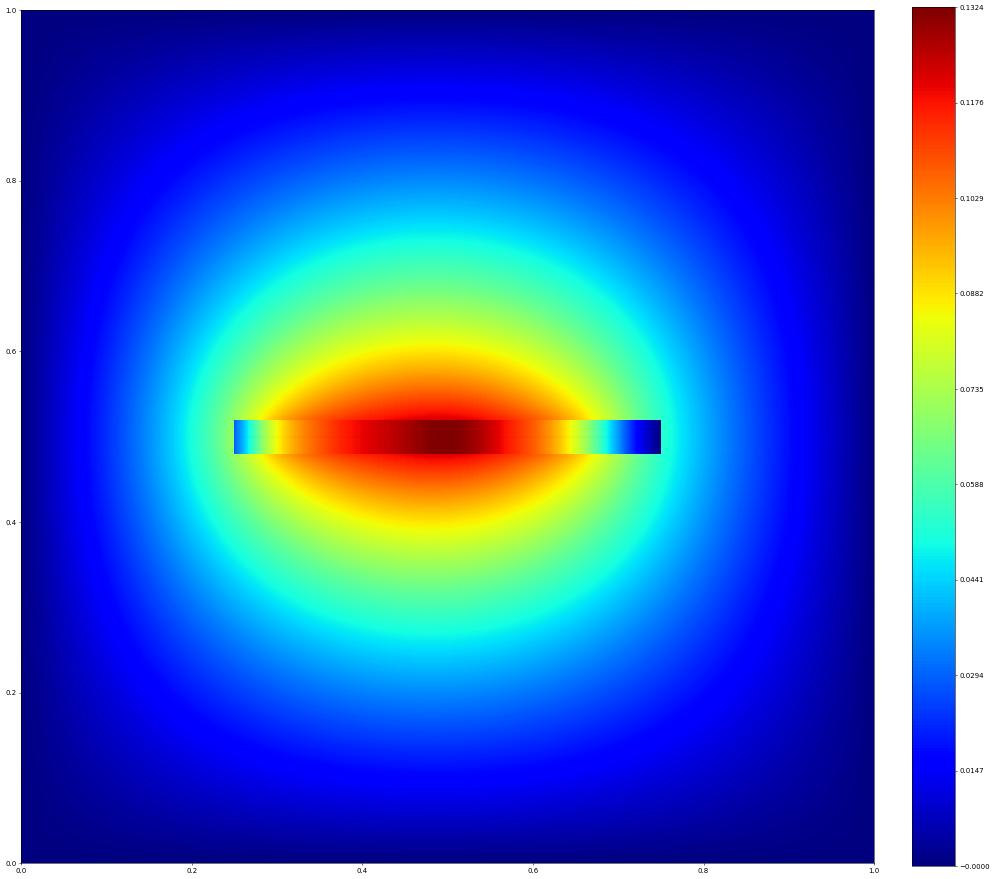

In [10]:

import matplotlib.pyplot as plt
from dune.fem.plotting import plotPointData as plot

figure = plt.figure(figsize=(20,20))
plot(uh, figure=figure, gridLines=None)
plot(iuh, figure=figure, linewidth=0.04, colorbar=None)
plt.show()